In [1]:
#| default_exp models.patchtst

# PatchTST

The PatchTST ...

**References**<br>
- [Haoyi Zhou, Shanghang Zhang, Jieqi Peng, Shuai Zhang, Jianxin Li, Hui Xiong, Wancai Zhang. "Informer: Beyond Efficient Transformer for Long Sequence Time-Series Forecasting"](https://arxiv.org/abs/2012.07436)<br>

In [2]:
#| export
import math
import numpy as np
from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F

from neuralforecast.common._base_windows import BaseWindows

from neuralforecast.losses.pytorch import MAE

/Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#| hide
from fastcore.test import test_eq
from nbdev.showdoc import show_doc

## 1. Backbone

### Auxiliary Functions

In [4]:
class Transpose(nn.Module):
    def __init__(self, *dims, contiguous=False): 
        super().__init__()
        self.dims, self.contiguous = dims, contiguous
    def forward(self, x):
        if self.contiguous: return x.transpose(*self.dims).contiguous()
        else: return x.transpose(*self.dims)

def get_activation_fn(activation):
    if callable(activation): return activation()
    elif activation.lower() == "relu": return nn.ReLU()
    elif activation.lower() == "gelu": return nn.GELU()
    raise ValueError(f'{activation} is not available. You can use "relu", "gelu", or a callable') 

### Positional Encoding

In [5]:
#| export
def PositionalEncoding(q_len, d_model, normalize=True):
    pe = torch.zeros(q_len, d_model)
    position = torch.arange(0, q_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    if normalize:
        pe = pe - pe.mean()
        pe = pe / (pe.std() * 10)
    return pe

SinCosPosEncoding = PositionalEncoding

def Coord2dPosEncoding(q_len, d_model, exponential=False, normalize=True, eps=1e-3):
    x = .5 if exponential else 1
    i = 0
    for i in range(100):
        cpe = 2 * (torch.linspace(0, 1, q_len).reshape(-1, 1) ** x) * (torch.linspace(0, 1, d_model).reshape(1, -1) ** x) - 1
        if abs(cpe.mean()) <= eps: break
        elif cpe.mean() > eps: x += .001
        else: x -= .001
        i += 1
    if normalize:
        cpe = cpe - cpe.mean()
        cpe = cpe / (cpe.std() * 10)
    return cpe

def Coord1dPosEncoding(q_len, exponential=False, normalize=True):
    cpe = (2 * (torch.linspace(0, 1, q_len).reshape(-1, 1)**(.5 if exponential else 1)) - 1)
    if normalize:
        cpe = cpe - cpe.mean()
        cpe = cpe / (cpe.std() * 10)
    return cpe

def positional_encoding(pe, learn_pe, q_len, d_model):
    # Positional encoding
    if pe == None:
        W_pos = torch.empty((q_len, d_model)) # pe = None and learn_pe = False can be used to measure impact of pe
        nn.init.uniform_(W_pos, -0.02, 0.02)
        learn_pe = False
    elif pe == 'zero':
        W_pos = torch.empty((q_len, 1))
        nn.init.uniform_(W_pos, -0.02, 0.02)
    elif pe == 'zeros':
        W_pos = torch.empty((q_len, d_model))
        nn.init.uniform_(W_pos, -0.02, 0.02)
    elif pe == 'normal' or pe == 'gauss':
        W_pos = torch.zeros((q_len, 1))
        torch.nn.init.normal_(W_pos, mean=0.0, std=0.1)
    elif pe == 'uniform':
        W_pos = torch.zeros((q_len, 1))
        nn.init.uniform_(W_pos, a=0.0, b=0.1)
    elif pe == 'lin1d': W_pos = Coord1dPosEncoding(q_len, exponential=False, normalize=True)
    elif pe == 'exp1d': W_pos = Coord1dPosEncoding(q_len, exponential=True, normalize=True)
    elif pe == 'lin2d': W_pos = Coord2dPosEncoding(q_len, d_model, exponential=False, normalize=True)
    elif pe == 'exp2d': W_pos = Coord2dPosEncoding(q_len, d_model, exponential=True, normalize=True)
    elif pe == 'sincos': W_pos = PositionalEncoding(q_len, d_model, normalize=True)
    else: raise ValueError(f"{pe} is not a valid pe (positional encoder. Available types: 'gauss'=='normal', \
        'zeros', 'zero', uniform', 'lin1d', 'exp1d', 'lin2d', 'exp2d', 'sincos', None.)")
    return nn.Parameter(W_pos, requires_grad=learn_pe)

### RevIN

In [6]:
#| export
class RevIN(nn.Module):
    def __init__(self, num_features: int, eps=1e-5, affine=True, subtract_last=False):
        """
        :param num_features: the number of features or channels
        :param eps: a value added for numerical stability
        :param affine: if True, RevIN has learnable affine parameters
        """
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        self.subtract_last = subtract_last
        if self.affine:
            self._init_params()

    def forward(self, x, mode:str):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else: raise NotImplementedError
        return x

    def _init_params(self):
        # initialize RevIN params: (C,)
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim-1))
        if self.subtract_last:
            self.last = x[:,-1,:].unsqueeze(1)
        else:
            self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        if self.subtract_last:
            x = x - self.last
        else:
            x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps*self.eps)
        x = x * self.stdev
        if self.subtract_last:
            x = x + self.last
        else:
            x = x + self.mean
        return 

### Encoder

In [7]:
#| export
class PatchTST_backbone(nn.Module):
    def __init__(self, c_in:int, context_window:int, target_window:int, patch_len:int, stride:int, max_seq_len:Optional[int]=1024, 
                 n_layers:int=3, d_model=128, n_heads=16, d_k:Optional[int]=None, d_v:Optional[int]=None,
                 d_ff:int=256, norm:str='BatchNorm', attn_dropout:float=0., dropout:float=0., act:str="gelu", key_padding_mask:bool='auto',
                 padding_var:Optional[int]=None, attn_mask:Optional[torch.Tensor]=None, res_attention:bool=True, pre_norm:bool=False, store_attn:bool=False,
                 pe:str='zeros', learn_pe:bool=True, fc_dropout:float=0., head_dropout = 0, padding_patch = None,
                 pretrain_head:bool=False, head_type = 'flatten', individual = False, revin = True, affine = True, subtract_last = False):
        
        super().__init__()
        
        # RevIn
        self.revin = revin
        if self.revin: self.revin_layer = RevIN(c_in, affine=affine, subtract_last=subtract_last)
        
        # Patching
        self.patch_len = patch_len
        self.stride = stride
        self.padding_patch = padding_patch
        patch_num = int((context_window - patch_len)/stride + 1)
        if padding_patch == 'end': # can be modified to general case
            self.padding_patch_layer = nn.ReplicationPad1d((0, stride)) 
            patch_num += 1
        
        # Backbone 
        self.backbone = TSTiEncoder(c_in, patch_num=patch_num, patch_len=patch_len, max_seq_len=max_seq_len,
                                n_layers=n_layers, d_model=d_model, n_heads=n_heads, d_k=d_k, d_v=d_v, d_ff=d_ff,
                                attn_dropout=attn_dropout, dropout=dropout, act=act, key_padding_mask=key_padding_mask, padding_var=padding_var,
                                attn_mask=attn_mask, res_attention=res_attention, pre_norm=pre_norm, store_attn=store_attn,
                                pe=pe, learn_pe=learn_pe)

        # Head
        self.head_nf = d_model * patch_num
        self.n_vars = c_in
        self.pretrain_head = pretrain_head
        self.head_type = head_type
        self.individual = individual

        if self.pretrain_head: 
            self.head = self.create_pretrain_head(self.head_nf, c_in, fc_dropout) # custom head passed as a partial func with all its kwargs
        elif head_type == 'flatten': 
            self.head = Flatten_Head(self.individual, self.n_vars, self.head_nf, target_window, head_dropout=head_dropout)

    def forward(self, z):                                                                   # z: [bs x nvars x seq_len]
        # norm
        if self.revin: 
            z = z.permute(0,2,1)
            z = self.revin_layer(z, 'norm')
            z = z.permute(0,2,1)

        # do patching
        if self.padding_patch == 'end':
            z = self.padding_patch_layer(z)
        z = z.unfold(dimension=-1, size=self.patch_len, step=self.stride)                   # z: [bs x nvars x patch_num x patch_len]
        z = z.permute(0,1,3,2)                                                              # z: [bs x nvars x patch_len x patch_num]

        # model
        z = self.backbone(z)                                                                # z: [bs x nvars x d_model x patch_num]
        z = self.head(z)                                                                    # z: [bs x nvars x target_window] 

        # denorm
        if self.revin: 
            z = z.permute(0,2,1)
            z = self.revin_layer(z, 'denorm')
            z = z.permute(0,2,1)
        return z
    
    def create_pretrain_head(self, head_nf, vars, dropout):
        return nn.Sequential(nn.Dropout(dropout),
                    nn.Conv1d(head_nf, vars, 1)
                    )


class Flatten_Head(nn.Module):
    def __init__(self, individual, n_vars, nf, target_window, head_dropout=0):
        super().__init__()
        
        self.individual = individual
        self.n_vars = n_vars
        
        if self.individual:
            self.linears = nn.ModuleList()
            self.dropouts = nn.ModuleList()
            self.flattens = nn.ModuleList()
            for i in range(self.n_vars):
                self.flattens.append(nn.Flatten(start_dim=-2))
                self.linears.append(nn.Linear(nf, target_window))
                self.dropouts.append(nn.Dropout(head_dropout))
        else:
            self.flatten = nn.Flatten(start_dim=-2)
            self.linear = nn.Linear(nf, target_window)
            self.dropout = nn.Dropout(head_dropout)
            
    def forward(self, x):                                 # x: [bs x nvars x d_model x patch_num]
        if self.individual:
            x_out = []
            for i in range(self.n_vars):
                z = self.flattens[i](x[:,i,:,:])          # z: [bs x d_model * patch_num]
                z = self.linears[i](z)                    # z: [bs x target_window]
                z = self.dropouts[i](z)
                x_out.append(z)
            x = torch.stack(x_out, dim=1)                 # x: [bs x nvars x target_window]
        else:
            x = self.flatten(x)
            x = self.linear(x)
            x = self.dropout(x)
        return x


class TSTiEncoder(nn.Module):  #i means channel-independent
    def __init__(self, c_in, patch_num, patch_len, max_seq_len=1024,
                 n_layers=3, d_model=128, n_heads=16, d_k=None, d_v=None,
                 d_ff=256, norm='BatchNorm', attn_dropout=0., dropout=0., act="gelu", store_attn=False,
                 key_padding_mask='auto', padding_var=None, attn_mask=None, res_attention=True, pre_norm=False,
                 pe='zeros', learn_pe=True):
        
        
        super().__init__()
        
        self.patch_num = patch_num
        self.patch_len = patch_len
        
        # Input encoding
        q_len = patch_num
        self.W_P = nn.Linear(patch_len, d_model)        # Eq 1: projection of feature vectors onto a d-dim vector space
        self.seq_len = q_len

        # Positional encoding
        self.W_pos = positional_encoding(pe, learn_pe, q_len, d_model)

        # Residual dropout
        self.dropout = nn.Dropout(dropout)

        # Encoder
        self.encoder = TSTEncoder(q_len, d_model, n_heads, d_k=d_k, d_v=d_v, d_ff=d_ff, norm=norm, attn_dropout=attn_dropout, dropout=dropout,
                                   pre_norm=pre_norm, activation=act, res_attention=res_attention, n_layers=n_layers, store_attn=store_attn)
        
    def forward(self, x) -> torch.Tensor:                                        # x: [bs x nvars x patch_len x patch_num]
        
        n_vars = x.shape[1]
        # Input encoding
        x = x.permute(0,1,3,2)                                                   # x: [bs x nvars x patch_num x patch_len]
        x = self.W_P(x)                                                          # x: [bs x nvars x patch_num x d_model]

        u = torch.reshape(x, (x.shape[0]*x.shape[1],x.shape[2],x.shape[3]))      # u: [bs * nvars x patch_num x d_model]
        u = self.dropout(u + self.W_pos)                                         # u: [bs * nvars x patch_num x d_model]

        # Encoder
        z = self.encoder(u)                                                      # z: [bs * nvars x patch_num x d_model]
        z = torch.reshape(z, (-1,n_vars,z.shape[-2],z.shape[-1]))                # z: [bs x nvars x patch_num x d_model]
        z = z.permute(0,1,3,2)                                                   # z: [bs x nvars x d_model x patch_num]
        
        return z    
            

class TSTEncoder(nn.Module):
    def __init__(self, q_len, d_model, n_heads, d_k=None, d_v=None, d_ff=None, 
                        norm='BatchNorm', attn_dropout=0., dropout=0., activation='gelu',
                        res_attention=False, n_layers=1, pre_norm=False, store_attn=False):
        super().__init__()

        self.layers = nn.ModuleList([TSTEncoderLayer(q_len, d_model, n_heads=n_heads, d_k=d_k, d_v=d_v, d_ff=d_ff, norm=norm,
                                                      attn_dropout=attn_dropout, dropout=dropout,
                                                      activation=activation, res_attention=res_attention,
                                                      pre_norm=pre_norm, store_attn=store_attn) for i in range(n_layers)])
        self.res_attention = res_attention

    def forward(self, src:torch.Tensor, key_padding_mask:Optional[torch.Tensor]=None, attn_mask:Optional[torch.Tensor]=None):
        output = src
        scores = None
        if self.res_attention:
            for mod in self.layers: output, scores = mod(output, prev=scores, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
            return output
        else:
            for mod in self.layers: output = mod(output, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
            return output


class TSTEncoderLayer(nn.Module):
    def __init__(self, q_len, d_model, n_heads, d_k=None, d_v=None, d_ff=256, store_attn=False,
                 norm='BatchNorm', attn_dropout=0, dropout=0., bias=True, activation="gelu", res_attention=False, pre_norm=False):
        super().__init__()
        assert not d_model%n_heads, f"d_model ({d_model}) must be divisible by n_heads ({n_heads})"
        d_k = d_model // n_heads if d_k is None else d_k
        d_v = d_model // n_heads if d_v is None else d_v

        # Multi-Head attention
        self.res_attention = res_attention
        self.self_attn = _MultiheadAttention(d_model, n_heads, d_k, d_v, attn_dropout=attn_dropout,
                                             proj_dropout=dropout, res_attention=res_attention)

        # Add & Norm
        self.dropout_attn = nn.Dropout(dropout)
        if "batch" in norm.lower():
            self.norm_attn = nn.Sequential(Transpose(1,2), nn.BatchNorm1d(d_model), Transpose(1,2))
        else:
            self.norm_attn = nn.LayerNorm(d_model)

        # Position-wise Feed-Forward
        self.ff = nn.Sequential(nn.Linear(d_model, d_ff, bias=bias),
                                get_activation_fn(activation),
                                nn.Dropout(dropout),
                                nn.Linear(d_ff, d_model, bias=bias))

        # Add & Norm
        self.dropout_ffn = nn.Dropout(dropout)
        if "batch" in norm.lower():
            self.norm_ffn = nn.Sequential(Transpose(1,2), nn.BatchNorm1d(d_model), Transpose(1,2))
        else:
            self.norm_ffn = nn.LayerNorm(d_model)

        self.pre_norm = pre_norm
        self.store_attn = store_attn

    def forward(self, src:torch.Tensor, prev:Optional[torch.Tensor]=None,
                key_padding_mask:Optional[torch.Tensor]=None,
                attn_mask:Optional[torch.Tensor]=None) -> torch.Tensor:

        # Multi-Head attention sublayer
        if self.pre_norm:
            src = self.norm_attn(src)
        ## Multi-Head attention
        if self.res_attention:
            src2, attn, scores = self.self_attn(src, src, src, prev,
                                                key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        else:
            src2, attn = self.self_attn(src, src, src, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        if self.store_attn:
            self.attn = attn
        ## Add & Norm
        src = src + self.dropout_attn(src2) # Add: residual connection with residual dropout
        if not self.pre_norm:
            src = self.norm_attn(src)

        # Feed-forward sublayer
        if self.pre_norm:
            src = self.norm_ffn(src)
        ## Position-wise Feed-Forward
        src2 = self.ff(src)
        ## Add & Norm
        src = src + self.dropout_ffn(src2) # Add: residual connection with residual dropout
        if not self.pre_norm:
            src = self.norm_ffn(src)

        if self.res_attention:
            return src, scores
        else:
            return src


class _MultiheadAttention(nn.Module):
    def __init__(self, d_model, n_heads, d_k=None, d_v=None,
                 res_attention=False, attn_dropout=0., proj_dropout=0., qkv_bias=True, lsa=False):
        """Multi Head Attention Layer
        Input shape:
            Q:       [batch_size (bs) x max_q_len x d_model]
            K, V:    [batch_size (bs) x q_len x d_model]
            mask:    [q_len x q_len]
        """
        super().__init__()
        d_k = d_model // n_heads if d_k is None else d_k
        d_v = d_model // n_heads if d_v is None else d_v

        self.n_heads, self.d_k, self.d_v = n_heads, d_k, d_v

        self.W_Q = nn.Linear(d_model, d_k * n_heads, bias=qkv_bias)
        self.W_K = nn.Linear(d_model, d_k * n_heads, bias=qkv_bias)
        self.W_V = nn.Linear(d_model, d_v * n_heads, bias=qkv_bias)

        # Scaled Dot-Product Attention (multiple heads)
        self.res_attention = res_attention
        self.sdp_attn = _ScaledDotProductAttention(d_model, n_heads, attn_dropout=attn_dropout,
                                                   res_attention=self.res_attention, lsa=lsa)

        # Poject output
        self.to_out = nn.Sequential(nn.Linear(n_heads * d_v, d_model), nn.Dropout(proj_dropout))

    def forward(self, Q:torch.Tensor, K:Optional[torch.Tensor]=None, V:Optional[torch.Tensor]=None, prev:Optional[torch.Tensor]=None,
                key_padding_mask:Optional[torch.Tensor]=None, attn_mask:Optional[torch.Tensor]=None):

        bs = Q.size(0)
        if K is None: K = Q
        if V is None: V = Q

        # Linear (+ split in multiple heads)
        q_s = self.W_Q(Q).view(bs, -1, self.n_heads, self.d_k).transpose(1,2)       # q_s    : [bs x n_heads x max_q_len x d_k]
        k_s = self.W_K(K).view(bs, -1, self.n_heads, self.d_k).permute(0,2,3,1)     # k_s    : [bs x n_heads x d_k x q_len] - transpose(1,2) + transpose(2,3)
        v_s = self.W_V(V).view(bs, -1, self.n_heads, self.d_v).transpose(1,2)       # v_s    : [bs x n_heads x q_len x d_v]

        # Apply Scaled Dot-Product Attention (multiple heads)
        if self.res_attention:
            output, attn_weights, attn_scores = self.sdp_attn(q_s, k_s, v_s,
                                                    prev=prev, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        else:
            output, attn_weights = self.sdp_attn(q_s, k_s, v_s, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        # output: [bs x n_heads x q_len x d_v], attn: [bs x n_heads x q_len x q_len], scores: [bs x n_heads x max_q_len x q_len]

        # back to the original inputs dimensions
        output = output.transpose(1, 2).contiguous().view(bs, -1, self.n_heads * self.d_v) # output: [bs x q_len x n_heads * d_v]
        output = self.to_out(output)

        if self.res_attention: return output, attn_weights, attn_scores
        else: return output, attn_weights


class _ScaledDotProductAttention(nn.Module):
    r"""Scaled Dot-Product Attention module (Attention is all you need by Vaswani et al., 2017) with optional residual attention from previous layer
    (Realformer: Transformer likes residual attention by He et al, 2020) and locality self sttention (Vision Transformer for Small-Size Datasets
    by Lee et al, 2021)"""

    def __init__(self, d_model, n_heads, attn_dropout=0., res_attention=False, lsa=False):
        super().__init__()
        self.attn_dropout = nn.Dropout(attn_dropout)
        self.res_attention = res_attention
        head_dim = d_model // n_heads
        self.scale = nn.Parameter(torch.tensor(head_dim ** -0.5), requires_grad=lsa)
        self.lsa = lsa

    def forward(self, q:torch.Tensor, k:torch.Tensor, v:torch.Tensor,
                prev:Optional[torch.Tensor]=None, key_padding_mask:Optional[torch.Tensor]=None,
                attn_mask:Optional[torch.Tensor]=None):
        '''
        Input shape:
            q               : [bs x n_heads x max_q_len x d_k]
            k               : [bs x n_heads x d_k x seq_len]
            v               : [bs x n_heads x seq_len x d_v]
            prev            : [bs x n_heads x q_len x seq_len]
            key_padding_mask: [bs x seq_len]
            attn_mask       : [1 x seq_len x seq_len]
        Output shape:
            output:  [bs x n_heads x q_len x d_v]
            attn   : [bs x n_heads x q_len x seq_len]
            scores : [bs x n_heads x q_len x seq_len]
        '''

        # Scaled MatMul (q, k) - similarity scores for all pairs of positions in an input sequence
        attn_scores = torch.matmul(q, k) * self.scale      # attn_scores : [bs x n_heads x max_q_len x q_len]

        # Add pre-softmax attention scores from the previous layer (optional)
        if prev is not None: attn_scores = attn_scores + prev

        # Attention mask (optional)
        if attn_mask is not None:                                     # attn_mask with shape [q_len x seq_len] - only used when q_len == seq_len
            if attn_mask.dtype == torch.bool:
                attn_scores.masked_fill_(attn_mask, -np.inf)
            else:
                attn_scores += attn_mask

        # Key padding mask (optional)
        if key_padding_mask is not None:                              # mask with shape [bs x q_len] (only when max_w_len == q_len)
            attn_scores.masked_fill_(key_padding_mask.unsqueeze(1).unsqueeze(2), -np.inf)

        # normalize the attention weights
        attn_weights = F.softmax(attn_scores, dim=-1)                 # attn_weights   : [bs x n_heads x max_q_len x q_len]
        attn_weights = self.attn_dropout(attn_weights)

        # compute the new values given the attention weights
        output = torch.matmul(attn_weights, v)                        # output: [bs x n_heads x max_q_len x d_v]

        if self.res_attention: return output, attn_weights, attn_scores
        else: return output, attn_weights

## 2. Model

In [8]:
#| export
class PatchTST(BaseWindows):
    def __init__(self,
                 h,
                 input_size, # 336
                 stat_exog_list = None,
                 hist_exog_list = None,
                 futr_exog_list = None,
                 # Architecture
                 encoder_layers: int = 3,
                 n_heads: int = 16,
                 hidden_size: int = 128,
                 linear_hidden_size: int = 256,
                 dropout: float = 0.2,
                 fc_dropout: float = 0.2,
                 head_dropout: float = 0.0,
                 patch_len: int = 16,
                 stride: int = 8,
                 padding_patch: str = 'end',
                 revin: bool = True,
                 revin_affine: bool = False,
                 revin_subtract_last:bool = True,
                 activation: str = "gelu",
                 attn_dropout: float =0.,
                 res_attention: bool = True, 
                 batch_normalization: bool = False,
                 learn_pos_embed: bool = True,
                 # Neuralforecast
                 loss = MAE(),
                 valid_loss = None,
                 max_steps: int = 5000,
                 learning_rate: float = 1e-4,
                 num_lr_decays: int = -1,
                 early_stop_patience_steps: int =-1,
                 val_check_steps: int = 100,
                 batch_size: int = 32,
                 valid_batch_size: Optional[int] = None,
                 windows_batch_size = 1024,
                 step_size: int = 1,
                 scaler_type: str = 'identity',
                 random_seed: int = 1,
                 num_workers_loader: int = 0,
                 drop_last_loader: bool = False,
                 **trainer_kwargs):
        super(PatchTST, self).__init__(h=h,
                                       input_size=input_size,
                                       hist_exog_list=hist_exog_list,
                                       stat_exog_list=stat_exog_list,
                                       futr_exog_list = futr_exog_list,
                                       loss=loss,
                                       valid_loss=valid_loss,
                                       max_steps=max_steps,
                                       learning_rate=learning_rate,
                                       num_lr_decays=num_lr_decays,
                                       early_stop_patience_steps=early_stop_patience_steps,
                                       val_check_steps=val_check_steps,
                                       batch_size=batch_size,
                                       windows_batch_size=windows_batch_size,
                                       valid_batch_size=valid_batch_size,
                                       step_size=step_size,
                                       scaler_type=scaler_type,
                                       num_workers_loader=num_workers_loader,
                                       drop_last_loader=drop_last_loader,
                                       random_seed=random_seed,
                                       **trainer_kwargs)        
        # Fixed hyperparameters
        c_in = 1                  # Always univariate
        pretrain_head = False     # No pretrained head
        norm = 'BatchNorm'        # Use BatchNorm (if batch_normalization is True)
        pe = 'zeros'              # Initial zeros for positional encoding 
        d_k = None                # Key dimension
        d_v = None                # Value dimension
        store_attn = False        # Store attention weights
        head_type = 'flatten'     # Head type
        individual = False        # Separate heads for each time series
        max_seq_len = 1024        # Not used
        key_padding_mask = 'auto' # Not used
        padding_var = None        # Not used
        attn_mask = None          # Not used

        self.model = PatchTST_backbone(c_in=c_in, context_window=input_size, target_window=h, patch_len=patch_len, stride=stride, 
                                max_seq_len=max_seq_len, n_layers=encoder_layers, d_model=hidden_size,
                                n_heads=n_heads, d_k=d_k, d_v=d_v, d_ff=linear_hidden_size, norm=norm, attn_dropout=attn_dropout,
                                dropout=dropout, act=activation, key_padding_mask=key_padding_mask, padding_var=padding_var, 
                                attn_mask=attn_mask, res_attention=res_attention, pre_norm=batch_normalization, store_attn=store_attn,
                                pe=pe, learn_pe=learn_pos_embed, fc_dropout=fc_dropout, head_dropout=head_dropout, padding_patch = padding_patch,
                                pretrain_head=pretrain_head, head_type=head_type, individual=individual, revin=revin, affine=revin_affine,
                                subtract_last=revin_subtract_last)
    
    
    def forward(self, windows_batch):           # x: [Batch, Input length, Channel]

        # Parse windows_batch
        insample_y    = windows_batch['insample_y']
        #insample_mask = windows_batch['insample_mask']
        #hist_exog     = windows_batch['hist_exog']
        #stat_exog     = windows_batch['stat_exog']
        #futr_exog     = windows_batch['futr_exog']

        # Add dimension for channel
        x = insample_y.unsqueeze(-1) # [Ws,L,1]

        x = x.permute(0,2,1)    # x: [Batch, Channel, Input length]
        x = self.model(x)
        x = x.permute(0,2,1)    # x: [Batch, Input length, Channel]

        forecast = self.loss.domain_map(x[:, -self.h:])
        
        return forecast

In [9]:
show_doc(PatchTST)

---

### PatchTST

>      PatchTST (h, input_size, stat_exog_list=None, hist_exog_list=None,
>                futr_exog_list=None, encoder_layers:int=3, n_heads:int=16,
>                hidden_size:int=128, linear_hidden_size:int=256,
>                dropout:float=0.2, fc_dropout:float=0.2,
>                head_dropout:float=0.0, patch_len:int=16, stride:int=8,
>                padding_patch:str='end', revin:bool=True,
>                revin_affine:bool=False, revin_subtract_last:bool=True,
>                activation:str='gelu', attn_dropout:float=0.0,
>                res_attention:bool=True, batch_normalization:bool=False,
>                learn_pos_embed:bool=True, loss=MAE(), valid_loss=None,
>                max_steps:int=5000, learning_rate:float=0.0001,
>                num_lr_decays:int=-1, early_stop_patience_steps:int=-1,
>                val_check_steps:int=100, batch_size:int=32,
>                valid_batch_size:Optional[int]=None, windows_batch_size=1024,
>                step_size:int=1, scaler_type:str='identity', random_seed:int=1,
>                num_workers_loader:int=0, drop_last_loader:bool=False,
>                **trainer_kwargs)

Hooks to be used in LightningModule.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| h |  |  |  |
| input_size |  |  | 336 |
| stat_exog_list | NoneType | None |  |
| hist_exog_list | NoneType | None |  |
| futr_exog_list | NoneType | None |  |
| encoder_layers | int | 3 | Architecture |
| n_heads | int | 16 |  |
| hidden_size | int | 128 |  |
| linear_hidden_size | int | 256 |  |
| dropout | float | 0.2 |  |
| fc_dropout | float | 0.2 |  |
| head_dropout | float | 0.0 |  |
| patch_len | int | 16 |  |
| stride | int | 8 |  |
| padding_patch | str | end |  |
| revin | bool | True |  |
| revin_affine | bool | False |  |
| revin_subtract_last | bool | True |  |
| activation | str | gelu |  |
| attn_dropout | float | 0.0 |  |
| res_attention | bool | True |  |
| batch_normalization | bool | False |  |
| learn_pos_embed | bool | True |  |
| loss | MAE | MAE() | Neuralforecast |
| valid_loss | NoneType | None |  |
| max_steps | int | 5000 |  |
| learning_rate | float | 0.0001 |  |
| num_lr_decays | int | -1 |  |
| early_stop_patience_steps | int | -1 |  |
| val_check_steps | int | 100 |  |
| batch_size | int | 32 |  |
| valid_batch_size | Optional | None |  |
| windows_batch_size | int | 1024 |  |
| step_size | int | 1 |  |
| scaler_type | str | identity |  |
| random_seed | int | 1 |  |
| num_workers_loader | int | 0 |  |
| drop_last_loader | bool | False |  |
| trainer_kwargs |  |  |  |

In [10]:
show_doc(PatchTST.fit, name='PatchTST.fit')

---

### PatchTST.fit

>      PatchTST.fit (dataset, val_size=0, test_size=0, random_seed=None)

Fit.

The `fit` method, optimizes the neural network's weights using the
initialization parameters (`learning_rate`, `windows_batch_size`, ...)
and the `loss` function as defined during the initialization.
Within `fit` we use a PyTorch Lightning `Trainer` that
inherits the initialization's `self.trainer_kwargs`, to customize
its inputs, see [PL's trainer arguments](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).

The method is designed to be compatible with SKLearn-like classes
and in particular to be compatible with the StatsForecast library.

By default the `model` is not saving training checkpoints to protect
disk memory, to get them change `enable_checkpointing=True` in `__init__`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`val_size`: int, validation size for temporal cross-validation.<br>
`test_size`: int, test size for temporal cross-validation.<br>

In [11]:
show_doc(PatchTST.predict, name='PatchTST.predict')

---

### PatchTST.predict

>      PatchTST.predict (dataset, test_size=None, step_size=1, random_seed=None,
>                        **data_module_kwargs)

Predict.

Neural network prediction with PL's `Trainer` execution of `predict_step`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`test_size`: int=None, test size for temporal cross-validation.<br>
`step_size`: int=1, Step size between each window.<br>
`**data_module_kwargs`: PL's TimeSeriesDataModule args, see [documentation](https://pytorch-lightning.readthedocs.io/en/1.6.1/extensions/datamodules.html#using-a-datamodule).

## Usage example

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.04it/s] 


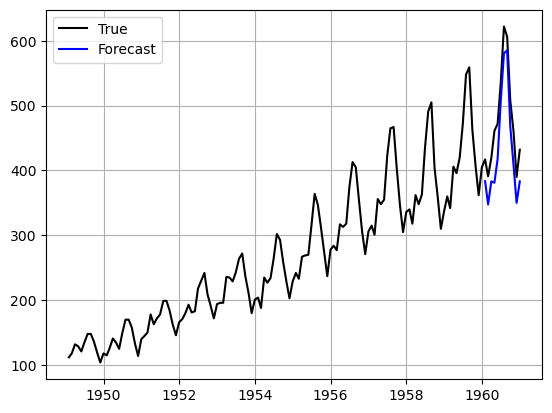

In [13]:
#| eval: false
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import MLP
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic, augment_calendar_df

AirPassengersPanel, calendar_cols = augment_calendar_df(df=AirPassengersPanel, freq='M')

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

model = PatchTST(h=12,
                 input_size=104,
                 patch_len=24,
                 stride=2,
                 revin=False,
                 hidden_size=16,
                 n_heads=4,
                 scaler_type='robust',
                 #loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
                 loss=MAE(),
                 learning_rate=1e-3,
                 max_steps=500,
                 val_check_steps=50,
                 early_stop_patience_steps=2)

nf = NeuralForecast(
    models=[model],
    freq='M'
)
nf.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
forecasts = nf.predict(futr_df=Y_test_df)

Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

if model.loss.is_distribution_output:
    plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
    plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
    plt.plot(plot_df['ds'], plot_df['PatchTST-median'], c='blue', label='median')
    plt.fill_between(x=plot_df['ds'][-12:], 
                    y1=plot_df['PatchTST-lo-90'][-12:].values, 
                    y2=plot_df['PatchTST-hi-90'][-12:].values,
                    alpha=0.4, label='level 90')
    plt.grid()
    plt.legend()
    plt.plot()
else:
    plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
    plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
    plt.plot(plot_df['ds'], plot_df['PatchTST'], c='blue', label='Forecast')
    plt.legend()
    plt.grid()